# Laboratorio 3 Malware detection
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285
Oscar Esteba Donis - 21610

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import tensorflow as tf

# Cargar el conjunto de datos
df = pd.read_csv("malware-dataset.csv", header=0)
df.head()

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


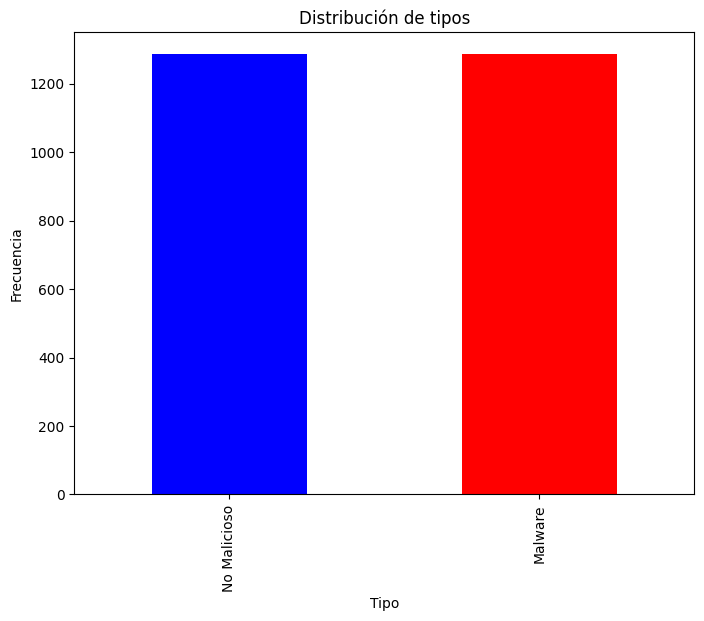

In [2]:
# creando la gráfica de distribucion de tipos 
plt.figure(figsize=(8, 6))
df['labels'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribución de tipos')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.gca().set_xticklabels(['No Malicioso', 'Malware'])
plt.show()

## Grafica de las llamadas a las APIs más comunes

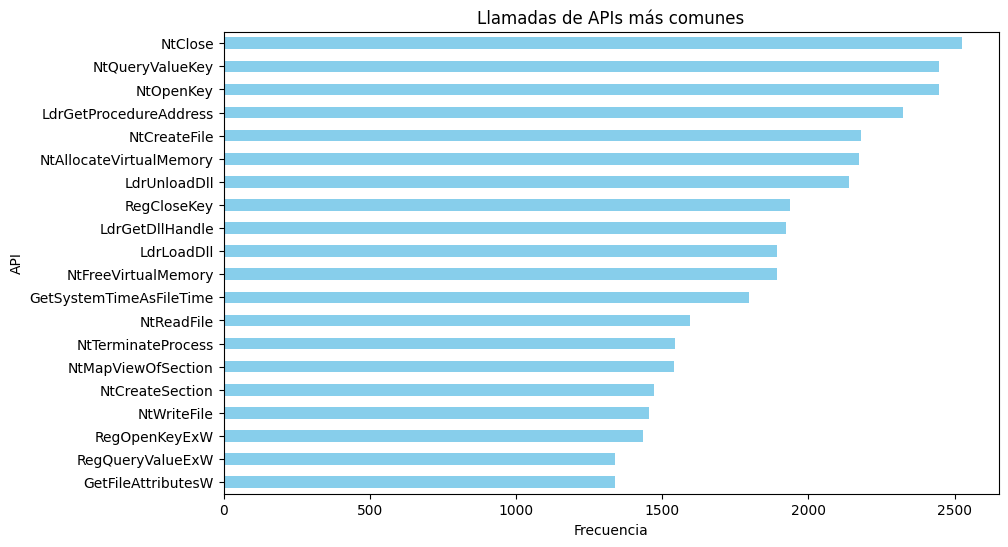

In [3]:
# llamadas a las APIs más comunes
llamadas_apis = df.drop(['sha256', 'labels'], axis=1).stack().value_counts() # contar las llamadas a las APIs
top_calls = llamadas_apis.head(20) # top 20 

plt.figure(figsize=(10, 6)) # graficar
top_calls.plot(kind='barh', color='skyblue') # graficar en barras horizontales
plt.title('Llamadas de APIs más comunes') # título de la gráfica
plt.xlabel('Frecuencia') # etiqueta en x 
plt.ylabel('API') # etiqueta en y 
plt.gca().invert_yaxis() # invertir el eje y para que aparezca la API más común en la parte superior
plt.show()

## Dividir datos en caracteristicas

In [5]:
le = LabelEncoder() # codificar las etiquetas
df = df.apply(le.fit_transform) # aplicar la codificación a las etiquetas del conjunto de datos

# Dividir el conjunto de datos en características y etiquetas
X = df.drop(['labels', 'sha256'], axis=1) # características 
y = df['labels'] # etiquetas

X

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,26,2,65,52,29,31,44,37,63,31,...,1,1,1,1,1,1,1,1,1,1
1,35,19,65,9,78,92,46,1,85,98,...,1,1,1,1,1,1,1,1,1,1
2,14,7,26,35,34,77,94,22,105,73,...,1,1,1,1,1,1,1,1,1,1
3,39,31,35,95,66,43,85,54,62,48,...,1,1,1,1,1,1,1,1,1,1
4,26,23,60,94,104,83,56,53,81,48,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,3,13,1,77,44,13,83,2,43,85,...,1,1,1,1,1,1,1,1,1,1
2566,31,62,39,68,93,83,78,93,71,66,...,1,1,1,1,1,1,1,1,1,1
2567,10,51,1,77,44,31,100,79,85,25,...,1,1,1,1,1,1,1,1,1,1
2568,28,30,90,21,33,44,45,70,85,51,...,1,1,1,1,1,1,1,1,1,1


In [9]:
print(X.shape)
print(y.shape)

(2570, 175)
(2570,)


In [10]:
print(y.value_counts())


labels
0    1285
1    1285
Name: count, dtype: int64


In [11]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
2565    1
2566    1
2567    1
2568    1
2569    1
Name: labels, Length: 2570, dtype: int64


## Primer Modelo